<img src="https://drive.google.com/uc?id=1-d7H1l1lJ28_sLcd9Vvh_N-yro7CJZcZ" style="Width:1000px">

# Seismic event in California: Earthquake or not?

In this data problem, you will try to train the best algorithm to detect man-made seismic event (a "quake") in California. We will use this as an opportunity to try out the two new `MLPClassifer` you encountered in the class, as well as `tuning` your algorithm. I am giving you the California Earthquakes dataset, with most columns still in. It is your decision what to do with the data (this is a data problem so close to what I would expect for your marked coursework). If you need more details about what the [columns names and what they mean you can be gather it from the USGS](https://earthquake.usgs.gov/data/comcat/data-eventterms.php).

For test consistency, **always use `random_state=42`** when you need a random state!

## Instructions

Open the `earthquakes.csv` dataset and do the following:

1. Looking at the `type` column, you will see that it contains the type of seismic event. Some are `earhquake`, some are other things (such as `quarry blast`, `nuclear blast`, etc... Using this information, create a new column called `target` that contains the boolean `True` (is man-made, i.e not an earthquake) and `False` (is  an earthquake). 
2. Create a target vector `y` that contains the `target` column, and a DataFrame `X` that contains all other features
3. Split your data (I suggest 80% train /20% test) and do an EDA on your `X_train` to understand the data
4. Prepare your data as you see fit based on your EDA. Pause to think what you are doing!
5. We are interested in the `precision` of our algorithm here: we want to make sure that when the algorithm tells us we are dealing with a man-made seismic event, we are over 91% confident that it is man-made. o
6. Train an `MLPClassifier` on your `X_train`. Use a `GridSearchCV` approach to find the best hyperparameters, focusing mostly on the network architecture (i.e. number of neurons in each layer, and number of layers), and the learning rate.
7. Because `MLPClassifier`s (and all deep-learning algorithms) are so slow to train, I will make a few suggestions here (take them or leave them). First, in your grid search, only train your algorithm with a `max_iter=20`. This will create ugly read warning that you have not converged, but it will be faster and will give you a first order idea of makes a difference. Then, I would suggest limiting your grid to any data preparation differences you might want to check (maybe 2 different pipeline?) and the following - hidden_layer_sizes:[(100,100,), (200,100,50,)], and alpha:[0.0001,0.01]. If you had more time, you could try more hyperparameters but you will see that training is indeed slow.  
8. Check which algorithm performs best using your `best_score_`. Save the best algorithm (`best_estimator_`) in a variable called `model`. If you have followed my instruction above, I suggest creating the `model` from scratch but using a `max_iter` value between 500-600, and then refit this new algorithm. This gets around the problem of training to 20 epochs only.
9. Using your best algorithm, estimate the final error using your `X_test` and save this as the variable `estimated_precision`.
10. Test your code agains unseen data!

### What will the `test` check?
The test for this exercise will assert wether:
1. Your overall `precision` is close to my results
2. Your `estimated_precision` is within `5%` of the actual precision of your algorithm on an unseen data (your `predictions.csv` file).

In [1]:
from nbta.utils import download_data
download_data(id='1YfrnkagRGdyGEOfQRkUuhCr0V_vnEKej')

In [2]:
import pandas as pd

dataset = pd.read_csv('raw_data/training_data.csv')
new_events = pd.read_csv('raw_data/seismic_events.csv')

<h1 style="color:green">FAIR WARNING:</h1>
<p>This solution is quite complete, and this is <strong style="color:blue">more than what you need to do to get a first class mark</strong> at the test. But it gives you a good idea of what a possible first class solution is, and what the best practice approach would be.</p>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
dataset

,type,time,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
0,earthquake,49:51.4,2.43,"7km NNE of Imperial, CA",reviewed,0,91,ci,21.0,0.08845,0.3500,129.00,ml,-115.531000,32.899833,10.000
1,earthquake,04:49.7,2.57,"14km SSE of Puebla, B.C., MX",reviewed,0,102,ci,23.0,0.37510,0.3900,202.00,ml,-115.309833,32.447500,6.006
2,earthquake,00:44.4,2.64,"Long Valley area, California",reviewed,0,107,nc,23.0,0.01712,0.0600,106.00,md,-118.846833,37.592167,7.145
3,earthquake,54:35.9,2.14,"33km ENE of Ensenada, B.C., MX",reviewed,0,70,ci,13.0,0.67530,0.2200,288.00,mh,-116.296333,31.991667,6.000
4,earthquake,03:03.7,2.99,"64km E of Maneadero, Mexico",reviewed,0,138,ci,21.0,0.24100,0.1400,158.00,ml,-115.886500,31.768833,17.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282002,earthquake,15:39.9,2.16,offshore Northern California,reviewed,0,72,nc,11.0,0.14410,0.0700,264.00,md,-124.458333,40.364667,6.479
282003,earthquake,54:22.3,2.10,Nevada,reviewed,0,68,nn,7.0,0.01400,0.1125,176.15,mb,-118.578300,38.068300,0.000
282004,earthquake,32:34.8,2.31,"26km E of Coso Junction, California",reviewed,0,82,ci,0.0,NaN,0.1650,231.20,mc,-117.666000,36.079000,0.632
282005,earthquake,35:06.6,2.40,Oregon,reviewed,0,89,uw,8.0,0.68090,0.4500,284.00,md,-122.092000,42.363000,10.120


In [9]:
dataset.value_counts()

type                time     mag   place                              status    tsunami  sig  net  nst   dmin    rms     gap     magType  longitude    latitude   depth  
earthquake          11:52.9  2.13  Central California                 reviewed  0        70   nc   5.0   0.1189  0.0200  182.00  md       -120.588500  36.020167   3.266     2
chemical explosion  00:00.0  2.02  Northern California                reviewed  0        63   nc   41.0  0.1009  0.6700  207.00  md       -121.553000  37.670167  -0.474     1
earthquake          42:36.1  2.99  offshore Northern California       reviewed  0        138  nc   25.0  0.2514  0.0700  243.00  md       -124.610667  40.329000   20.869    1
                    42:36.0  2.27  20km NNE of Kernville, CA          reviewed  0        79   ci   23.0  0.1559  0.1900  193.00  mc       -118.320500  35.914000   0.642     1
                             2.60  Nevada                             reviewed  0        104  nn   17.0  0.0540  0.1277  84.06   m

### Creating the `target` column
This can easily be done by using a lambda function in apply:

In [10]:
dataset['target'] = dataset.type.apply(lambda x: x!='earthquake')

In [11]:
dataset.duplicated().sum()

1

In [13]:
dataset.drop_duplicates(inplace=True)

In [14]:
dataset.duplicated().sum()

0

In [15]:
y = dataset.target.copy()
X = dataset.drop(columns = ['type', 'target']) # Dropping both target and type here

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)

# EDA

Let's explore our dataset, including the target variable:

In [17]:
y_train.value_counts()

target
False    211026
True      14578
Name: count, dtype: int64

Clearly, we have a heavily imbalanced dataset with 10x more earthquakes than non-earthquakes. This might impact our performance, so we will test it later.

In [18]:
X_train.dtypes

time          object
mag          float64
place         object
status        object
tsunami        int64
sig            int64
net           object
nst          float64
dmin         float64
rms          float64
gap          float64
magType       object
longitude    float64
latitude     float64
depth        float64
dtype: object

We have a mix of numerical and categorical data. Some of the data is not going to be helpful to determine the nature of the event: `time`, `latitude`, `longitude` and `place` can be ignored as we cannot rely on location or time to know for sure what the event was. In fact, this could lead to spurious learning so we will not use that.

Let's see the nature of the other categorical columns!

In [20]:
test = X_train.select_dtypes(include = 'object').columns.tolist()
test

['time', 'place', 'status', 'net', 'magType']

In [21]:
cat_data = X_train.select_dtypes(include = 'object').columns.tolist()
cat_data = [item for item in cat_data if item not in ['time','latitude','longitude','place']]
cat_data

['status', 'net', 'magType']

In [22]:
for item in cat_data:
    print(X_train[item].value_counts())
    print("----------------------------")

status
reviewed     220133
automatic      5253
AUTOMATIC       117
REVIEWED         93
manual            6
MANUAL            2
Name: count, dtype: int64
----------------------------
net
ci        108771
nc         75521
uw         14620
us          8657
nn          8559
uu          8131
mb          1323
ushis         16
iscgem         6
Name: count, dtype: int64
----------------------------
magType
md       88735
ml       71946
mc       46722
mh       12945
mb        2760
mw        1313
mwr        278
ma         190
mlr        186
Md         150
mwc        143
mww         76
Ml          60
ms          59
mwb         18
mdl          8
mun          8
mblg         2
mb_lg        1
ms_20        1
Name: count, dtype: int64
----------------------------


**Conclusion:** The `status` is not going to help us much as it represents whether the event was reviewed or not. I will choose to ignore it. The `net` is the network used to detect the event. This could potentially be useful. `magType` too but there are many values so we risk increasing the dimensionality of our dataset.

So we will only keep `net` as our `cat_data`!

In [23]:
cat_data = 'net'

In [24]:
X_train.describe()

,mag,tsunami,sig,nst,dmin,rms,gap,longitude,latitude,depth
count,225604.000000,225604.000000,225604.000000,218689.000000,163226.000000,223105.000000,221093.000000,225604.000000,225604.000000,225600.000000
mean,2.503949,0.000621,101.889364,20.515357,0.198303,0.197736,120.896811,-118.584996,36.999048,6.283907
std,0.510523,0.024903,56.120994,23.955350,0.297159,0.454591,82.331939,3.336044,4.005114,6.228916
min,2.000000,0.000000,62.000000,0.000000,0.000000,0.000000,0.000000,-131.771000,24.007000,-3.500000
25%,2.140000,0.000000,70.000000,0.000000,0.038740,0.080000,57.000000,-121.239417,34.051458,2.225750
50%,2.350000,0.000000,85.000000,14.000000,0.089190,0.150000,92.000000,-118.096000,36.192083,5.389000
75%,2.700000,0.000000,112.000000,30.000000,0.224000,0.230000,174.400000,-116.320000,38.819500,8.787250
max,7.300000,1.000000,2910.000000,659.000000,5.654000,71.450000,360.000000,-107.001000,50.000000,227.400000


We already determined that `latitude` and `longitude` could be droped so we will ignore that. What is interesting is that `tsunami` ranges from `0` to `1`: this could indicated an encoded categorical data so let's check:

In [25]:
X_train.tsunami.value_counts()

tsunami
0    225464
1       140
Name: count, dtype: int64

As we suspected, this is indeed a categorical data so it should not be scaled or considered in the same way as true numerical data. Let's create a `num_data` list and then plot a `scatter_matrix` and a `heatmap`:

In [33]:
num_data = X_train.select_dtypes(exclude=['object']).columns.tolist()
num_data = [item for item in num_data if item not in ['latitude', 'longitude', 'tsunami']]
cat_encoded = ['tsunami']

In [34]:
num_data

['mag', 'sig', 'nst', 'dmin', 'rms', 'gap', 'depth']

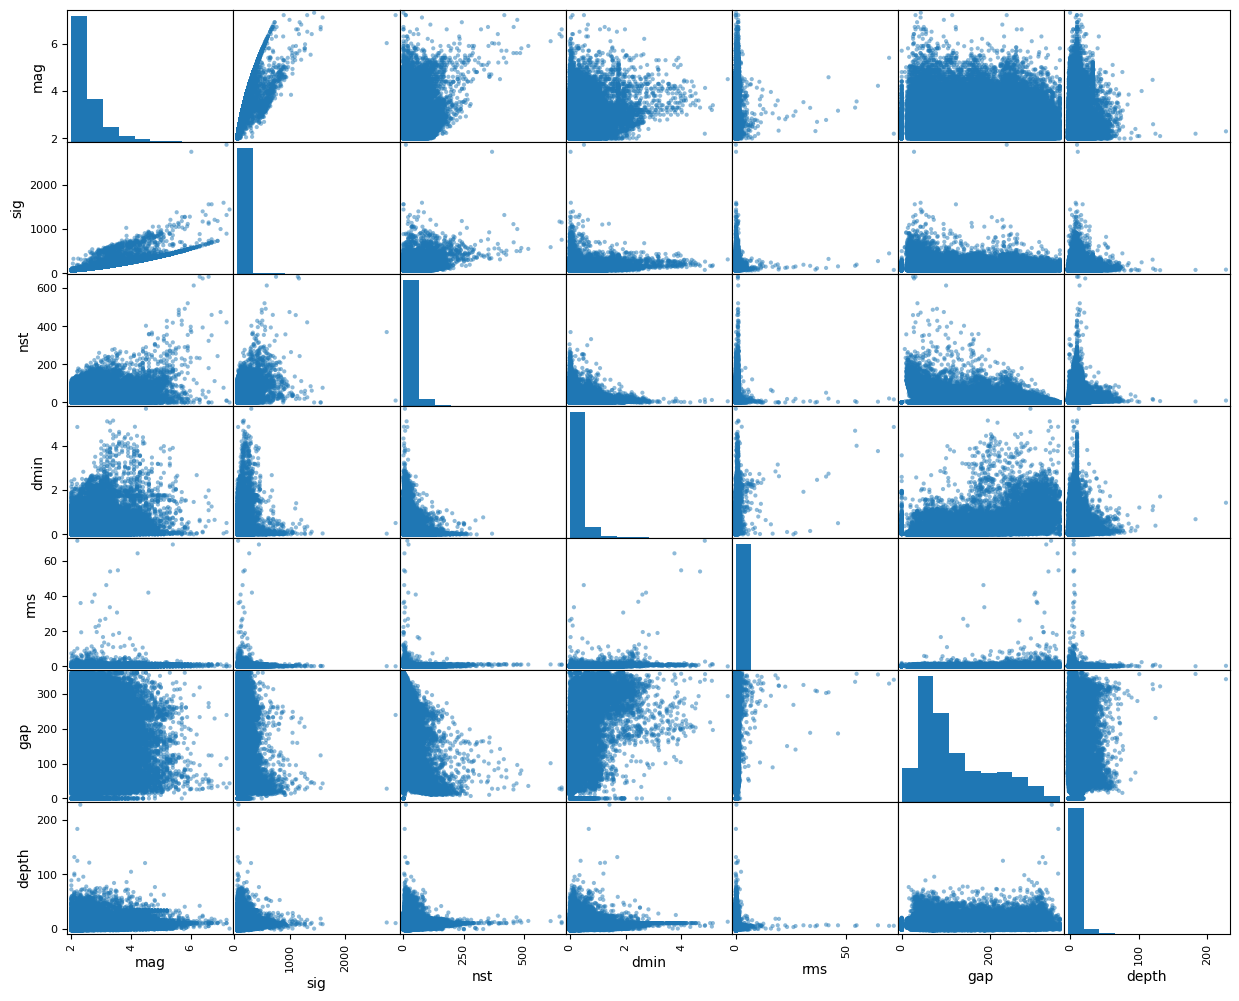

In [35]:
pd.plotting.scatter_matrix(X_train[num_data], figsize=(15,12));

**Conclusion:** We see here that `mag` and `sig` are fairly strongly correlated (we will check this later). It also appears that many of the feature distributions are non-gaussian. What if we were to take the log of the features?

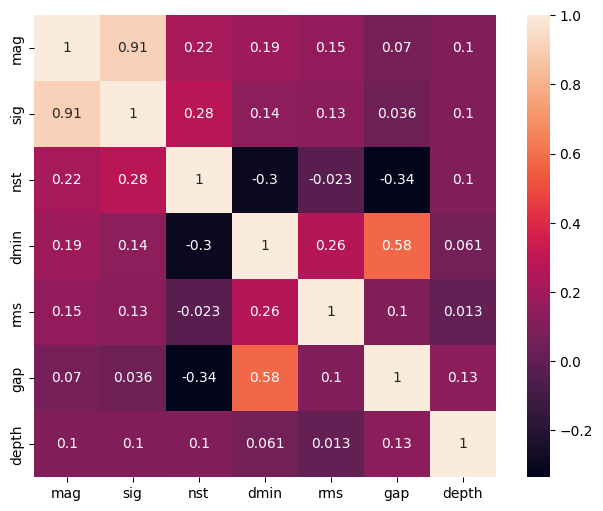

In [36]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(8,6))
corr = X_train[num_data].corr()
sns.heatmap(data=corr, annot=corr, ax=ax, square=True);

This confirms that `mag` and `sig` are strongly correlated: let's drop `sig`:

In [37]:
num_data.remove('sig')

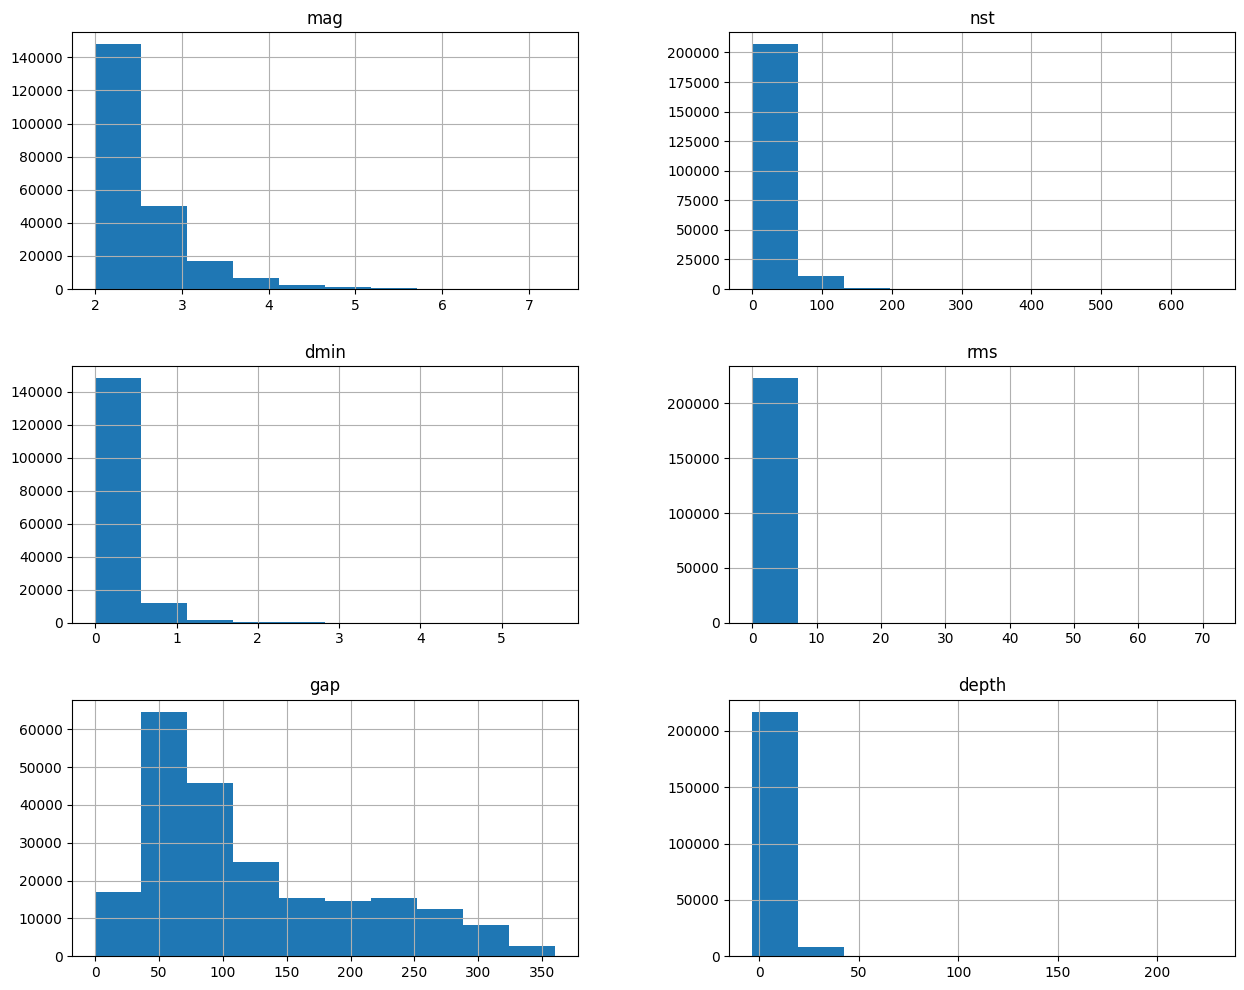

In [39]:
X_train[num_data].hist(figsize=(15,12));

/Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


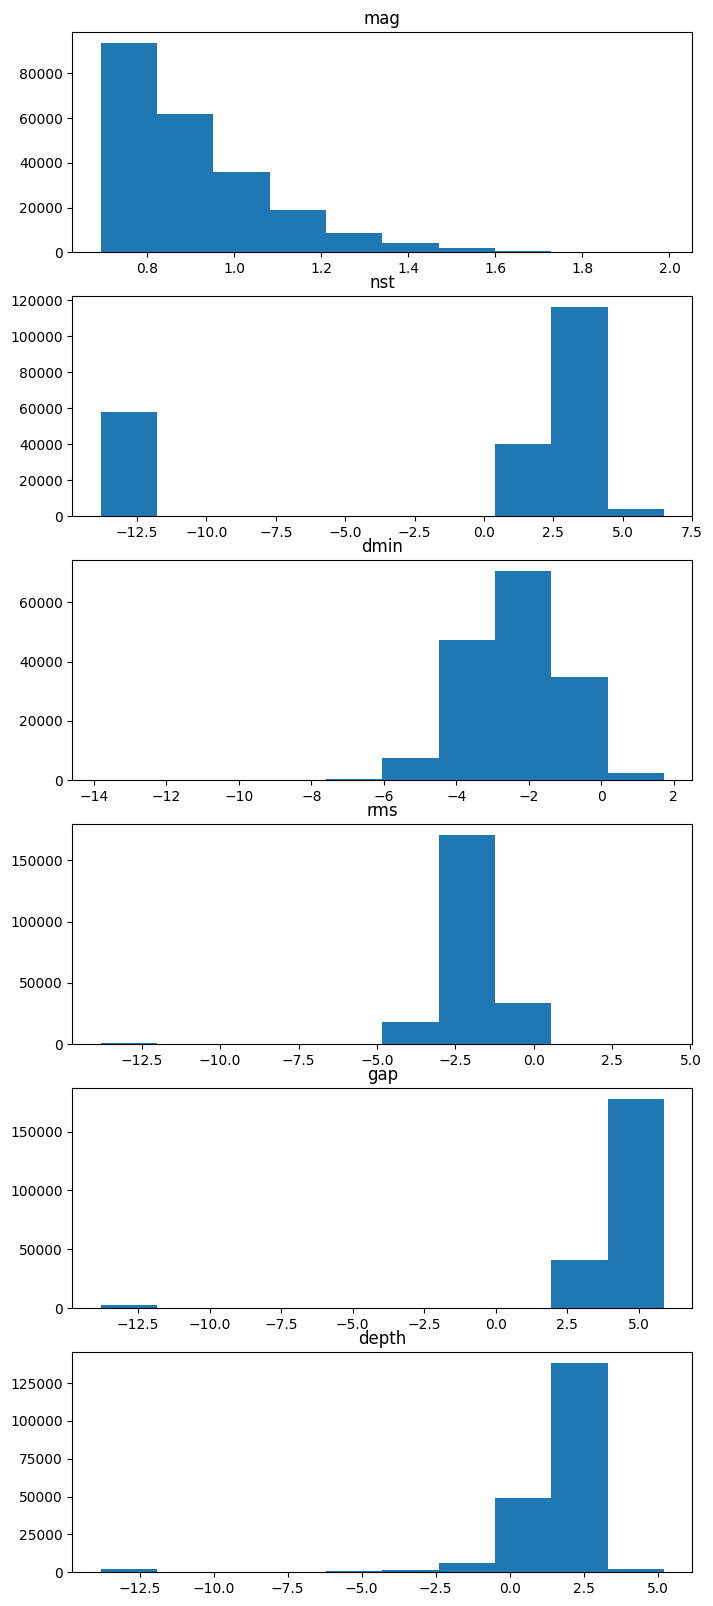

In [23]:
fig, axes = plt.subplots(len(num_data), 1, figsize=(8,20))

for feature, ax in zip(X_train[num_data], axes):
    ax.hist(np.log(X_train[feature]+1e-6));
    ax.set_title(feature)

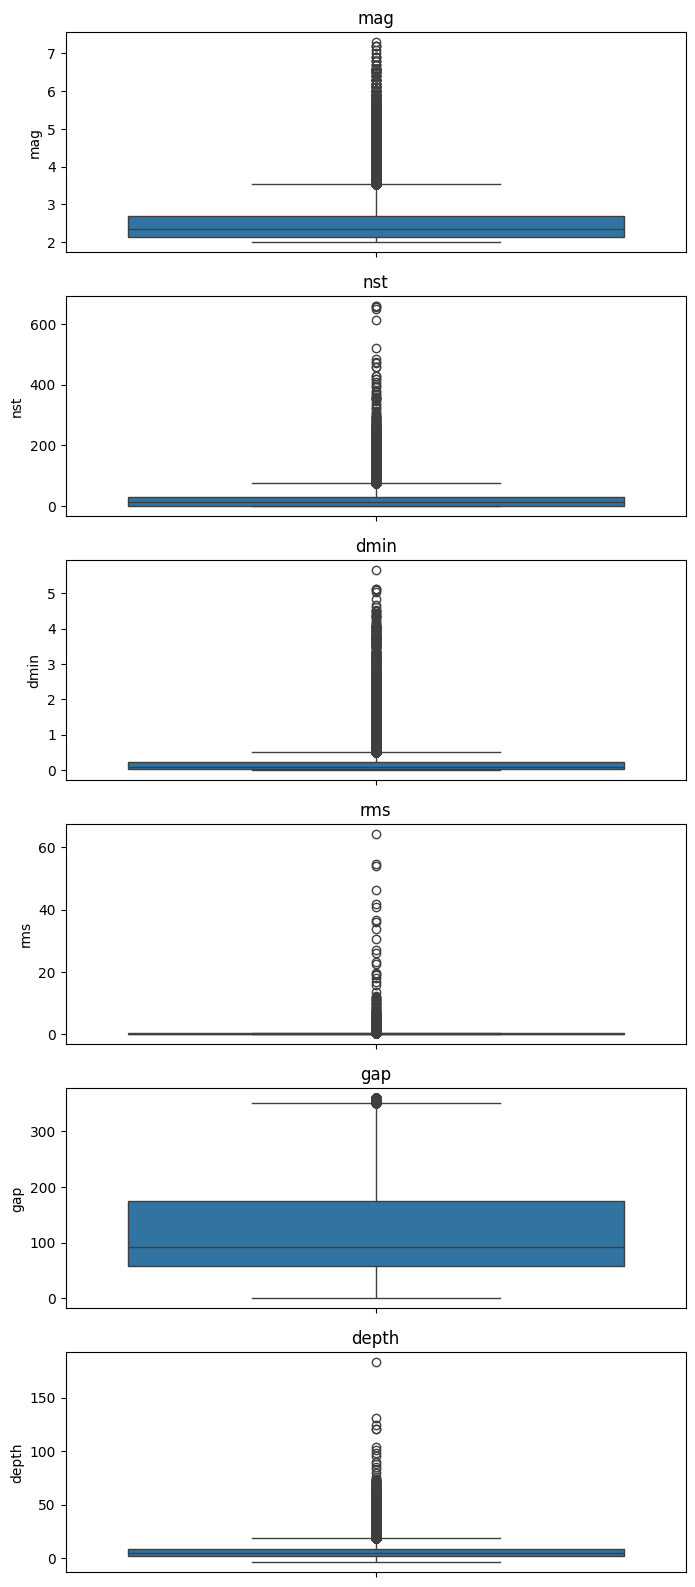

In [24]:
fig, axes = plt.subplots(len(num_data),1, figsize=(8,20))

for feature, ax in zip(X_train[num_data], axes):
    sns.boxplot(data = X_train[feature], ax=ax);
    ax.set_title(feature)

**Conclusion:** The data does not have obvious outliers, however, `dmin` and `gap` might benefit from some log-transform though it is unclear. I tested both approaches, and not transforming the data gave a small boost in performance.

# Data Preparation pipelines

I will now do the following:
1. I will create a very simple pipeline that will only take the numerical features into consideration. This is a naive approach, but I will test this in my GridSearch further down the line - it will cost me training time, but will ensure I choose the best (most effective) strategy.
2. I will create a second pipeline that includes the categorical data. After iteratively testing my pipeline, I came to the conclusions that `tsunami` was hurting performance rather than helping so it is not included here.
3. Because I know there is a heavy imbalance in my dataset, I will also create a `Transformer` class that under-samples the `earthquake` category to balance the `X_train`. I will keep my `X_test` with the original imbalance so I can test what I am doing. I will use this transformer to create an `X_train_balanced` and an `y_train_balanced` object.
4. I will create two final pipelines, and test them both with the smaller balanced dataset, and with the full imbalanced dataset.


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipe = make_pipeline(SimpleImputer(), StandardScaler(), )
simple_pipe = ColumnTransformer([('num',num_pipe, num_data)])

cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
cat_encoded_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

complete_pipe = ColumnTransformer([('num',num_pipe, X_train.select_dtypes(exclude='object').columns),
                                  ('cat', cat_pipe, ['net'])])

In [44]:
complete_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['net'])])

## Balance transformer
I create a transformer here, but note that this cannot be used in a pipeline because it needs to return a balanced `X` but also `y`. This breaks the transformer architecture in sklearn. So I will need to use it as a preprocessing step, and redo my training of the grid_search twice.

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryBalancingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, is_training=True):
        self.is_training = is_training

    def set_training(self, training_state):
        self.is_training = training_state

    def fit(self, X, y):
        self.is_training = True
        self.X_train = X.copy()
        self.X=X.copy()
        self.X['y']=y.copy()
        self.X.reset_index(drop=True, inplace=True)
        
        balance_data = self.X.y.value_counts().sort_values(ascending=False)
        
        self.majority_class = balance_data.index[0]
        self.minority_nb = balance_data.iloc[1]

        return self

    def balance(self):
        X=self.X.copy()
        
        majority_idx = X.y.loc[X.y==self.majority_class].sample(self.minority_nb).index.values
        minority_idx = X.y.loc[X.y!=self.majority_class].index.values
  
        Xs = pd.concat([X.iloc[majority_idx],X.iloc[minority_idx]])
        
        Xs = Xs.sample(frac=1)

        return (Xs.drop(columns='y'), Xs.y)
        
    def transform(self, X,y=None):
        if self.X_train.equals(X):
            return self.balance()
        return X

### Balancing the data
let's create an `X_train_balanced` and `y_train_balanced` version of the dataset:

In [47]:
balance = BinaryBalancingTransformer()
balance.fit(X_train,y_train)

X_train_balanced, y_train_balanced = balance.transform(X_train)


# Dummy Classifier

As always, we need to know what a random score would be. We can use an `sklearn` dummy classifier in our pipeline, and test the precision of our classifier with  the `simple_pipe` and the `imbalanced` dataset using cross validation. This will give us a baseline to beat.

In [49]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate

dummy = DummyClassifier(strategy='stratified')

# Let's do the simple pipe first:
np.mean(cross_val_score(X=X_train, y=y_train, estimator=make_pipeline(simple_pipe, dummy)))


0.8785837135756793

**conclusion**: Ouch! This is already a very high score, and it is random. This means the imbalance is really playing havoc on our `accuracy` here. So we will need to look at the score of our classifiers with care below: 90% means only 2% random accuracy, for instance.

# Training with our MLPClassifier (balanced dataset)

Here we will create a grid search to find the best hyperparamters for our data, using the balanced dataset first.

### Creating our final pipeline
We need to add the classifer for our pipeline so we can change things in it. We initiate it wiht the "simple_pipe" but we can change this in the grid!

In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


final_pipe = make_pipeline(simple_pipe, MLPClassifier(max_iter=20))

# Always good to visualise our parameters to know how to enter them in our grid
final_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['mag', 'nst', 'dmin', 'rms', 'gap',
                                     'depth'])])),
  ('mlpclassifier', MLPClassifier(max_iter=20))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  ['mag', 'nst', 'dmin', 'rms', 'gap',
                 

In [52]:
final_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['mag', 'nst', 'dmin', 'rms',
                                                   'gap', 'depth'])])),
                ('mlpclassifier', MLPClassifier(max_iter=20))])

### Create the grid and Grid Search

I will test the two preparating pipelines (with and without categorical data) as well as the architecture and regularization strength that I gave in the exercise description. I will call this search the `mlp_search_balanced`. I need to use `precision` as my metric (as this is what I am going for) and I will use a `cv=5`:

In [53]:
grid = {
    'columntransformer':[simple_pipe, complete_pipe], # This changes the data processing for our classifier
    'mlpclassifier__hidden_layer_sizes':[(100,100,), (200,100,50,)],
    'mlpclassifier__alpha':[0.0001,0.01]
}

mlp_search_balanced = GridSearchCV(final_pipe, param_grid=grid, 
                      cv=5, n_jobs=-1, scoring='precision')

In [54]:
mlp_search_balanced.fit(X_train_balanced, y_train_balanced)

/Users/shiyunwa/anaconda3/envs/ese-msc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shiyunwa/anaconda3/envs/ese-msc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shiyunwa/anaconda3/envs/ese-msc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shiyunwa/anaconda3/envs/ese-msc/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converge

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['mag',
                                                                          'nst',
                                                                          'dmin',
                                                                          'rms',
                                                                          'gap',
                                                                          'depth'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=20))]),
             n_jobs=-1,
             param_grid={'columntransformer': [ColumnTransformer(trans...
                                                                                Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['net'])])],
                         'mlpclassifier__alpha': [0.0001, 0.01],
                         'mlpclassifier__hidden_layer_sizes': [(100, 100),
                                                               (200, 100, 50)]},
             scoring='precision')

### Find the best paramters

In [28]:
mlp_search_balanced.best_params_

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
        'latitude', 'depth'],
       dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['net'])]),
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__hidden_layer_sizes': (200, 100, 50)}

**Conclusion**: Using the categorical data this help, as well as the stronger regularization and larger network.

In [29]:
# Checking our best score from cross-validation:
mlp_balanced_score = mlp_search_balanced.best_score_
mlp_balanced_score

0.9497059687211411

# Training using the imbalanced dataset

Now we can create a new algorithm (`mlp_search_imbalanced`) and train it on the full `X_train` and `y_train` using the same grid:

In [30]:
mlp_search_imbalanced = GridSearchCV(final_pipe, param_grid=grid, 
                      cv=5, n_jobs=-1, scoring='precision')

In [31]:
mlp_search_imbalanced.fit(X_train, y_train)

/Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['mag',
                                                                          'nst',
                                                                          'dmin',
                                                                          'rms',
                                                                          'gap',
                                                                          'depth'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=20))]),
             n_jobs=-1,
             param_grid={'columntransformer': [ColumnTransformer(trans...
                                                                                Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')),
                                                                               ('cat',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['net'])])],
                         'mlpclassifier__alpha': [0.0001, 0.01],
                         'mlpclassifier__hidden_layer_sizes': [(100, 100),
                                                               (200, 100, 50)]},
             scoring='precision')

### Best params and best score:

In [33]:
mlp_search_imbalanced.best_params_

{'columntransformer': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer()),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
        'latitude', 'depth'],
       dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['net'])]),
 'mlpclassifier__alpha': 0.01,
 'mlpclassifier__hidden_layer_sizes': (100, 100)}

In [34]:
mlp_search_imbalanced.best_score_

0.9176373051207

# Assessing our estimator critically

On the face of it, the `mlp_search_balanced` outperformed the imbalanced version. But we need to be careful: we have assessed the balanced version on an artificially balanced set (the cross-validation uses the balanced `X_train`). How do both algorithm perform on an unseen, imbalanced dataset? This is where our `X_test` can be useful:

In [36]:
best_balanced_estimator = mlp_search_balanced.best_estimator_
best_imbalanced_estimator = mlp_search_imbalanced.best_estimator_

In [38]:
from sklearn.metrics import precision_score
print(precision_score(y_test, best_balanced_estimator.predict(X_test)))
print(precision_score(y_test, best_imbalanced_estimator.predict(X_test)))

0.6140102600389173
0.9008633521881513


**Conclusions**: the `MLPClassifier` trained an the imbalanced dataset is clearly better than the other one. Why? In most cases, it makes sense to balance a dataset. But neural network require a lot of data, and by discarding 90% of the earthquake we have made the dataset poorer. So in this case, it was worth testing both approaches and we will use the imbalanced classifier for our final prediction. 

# Retraining with more epochs
Now let's take the best hyperparameters, change the `max_iter` to 600, but also set the `early_stopping` to `True` and `n_iter_no_change` (when to stop training) to `50`. Then we can save our `estimated_precision` variable:

In [39]:
model = make_pipeline(complete_pipe, 
                      MLPClassifier(alpha=0.0001, hidden_layer_sizes=(200, 100, 50), early_stopping=True, n_iter_no_change=50, max_iter=600))

In [40]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['net'])])),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(200, 100, 50), max_iter=600,
                               n_iter_no_change=50))])

In [41]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['mag', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'longitude',
       'latitude', 'depth'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['net'])])),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(200, 100, 50), max_iter=600,
                               n_iter_no_change=50))])

In [42]:
from sklearn.metrics import precision_score

estimated_precision = precision_score(y_test, model.predict(X_test))
estimated_precision

0.9393766085215899

**Conclusion:** This is a pretty good score. Now we can make the predictions on the `seismic_events.csv` file.

# Making the predictions on new samples and saving

In [44]:
y_pred = pd.Series(model.predict(new_events), name='y_pred')
y_pred

0        False
1        False
2         True
3        False
4        False
         ...  
31330    False
31331    False
31332    False
31333    False
31334    False
Name: y_pred, Length: 31335, dtype: bool

In [45]:
y_pred.to_csv('predictions.csv', index=False) # If we don't use index=False, the index will be saved in the file as a feature...

### ☑️ Test your code

In [68]:
from nbresult import ChallengeResult

result = ChallengeResult('model_score',
                         estimated_precision = estimated_precision
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.11.2, pytest-7.4.2, pluggy-1.3.0 -- /Users/cedric/.pyenv/versions/3.10/envs/dsml4pe/bin/python3
cachedir: .pytest_cache
rootdir: /Users/cedric/code/cedricmjohn/teaching/Machine-Learning-for-Planet-Earth-Practicals/06-Model-Tuning/03-Predicting-Earthquakes/tests
plugins: anyio-4.0.0
collecting ... collected 2 items

test_model_score.py::TestModel_score::test_predicted_score PASSED        [ 50%]
test_model_score.py::TestModel_score::test_score PASSED                  [100%]

============================== 2 passed in 0.52s ===============================


💯 You can commit your code:

git add tests/model_score.pickle

git commit -m 'Completed model_score step'

git push origin master



# 🏁 Finished!

Well done! <span style="color:teal">**Push your exercise to GitHub**</span>, and move on to the next one.